# [모의 캐글] 비매너 댓글 식별 

- 자연어 multi label classification 과제




# 1. 환경 설정 및 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/traffic forecasting/Project1/comments identification/baseline_v2/'

In [ ]:
!pip install -r '/content/drive/MyDrive/Colab Notebooks/traffic forecasting/Project1/comments identification/baseline_v2/requirements.txt'

     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 6.5 MB 51.6 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import os
import json
import numpy as np
import shutil

from sklearn.metrics import f1_score
from datetime import datetime, timezone, timedelta
import random
from tqdm import tqdm


from attrdict import AttrDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils import *
from torch.optim import Adam, AdamW

from sklearn.metrics import f1_score

from transformers import logging, get_linear_schedule_with_warmup


from transformers import ( 
    BertConfig,
    ElectraConfig
)

### v2 에서 라이브러리 추가됨
# 실험에 사용하실 모델 라이브러리를 추가하시는 걸 잊지 마세요!

from transformers import (
    BertTokenizer,  
    AutoTokenizer,
    ElectraTokenizer,
    AlbertTokenizer
)

from transformers import (
    BertModel,
    AutoModel, 
    ElectraForSequenceClassification,
    AutoModelForSequenceClassification,
    BertForSequenceClassification,
    AlbertForSequenceClassification
)


In [ ]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


In [ ]:
# True 일 때 코드를 실행하면 example 등을 보여줌
DEBUG = False

In [ ]:
# config 파일 불러오기
config_path = os.path.join(PATH, 'config.json')

def set_config(config_path):
    if os.path.lexists(config_path):
        with open(config_path) as f:
            args = AttrDict(json.load(f))
            print("config file loaded.")
            print(args.pretrained_model)
    else:
        assert False, 'config json file cannot be found.. please check the path again.'
    
    return args


# 코드 중간중간에 끼워넣어 리셋 가능
args = set_config(config_path)

# 결과 저장 폴더 미리 생성
os.makedirs(args.result_dir, exist_ok=True)
os.makedirs(args.config_dir, exist_ok=True)

config file loaded.
beomi/kcbert-large


# 2. EDA 및 데이터 전처리

In [ ]:
# data 경로 설정  
train_path = os.path.join(args.data_dir,'back taranslation train.csv')

print("train 데이터 경로가 올바른가요? : ", os.path.lexists(train_path))


train 데이터 경로가 올바른가요? :  True


### 2-1. Train 데이터 확인

In [ ]:
train_df = pd.read_csv(train_path, encoding = 'UTF-8-SIG')
train_df = train_df.fillna("")
train_df.loc[train_df['google title'].isnull() == True]

,title,comment,bias,hate,pororo title,pororo comment,papago title,papago comment,google title,google comment


In [ ]:
train_df.head()

,title,comment,bias,hate,pororo title,pororo comment,papago title,papago comment,google title,google comment
0,미스터 션샤인 변요한 김태리와 같은 양복 입고 학당 방문 이유는,김태리 정말 연기잘해 진짜,none,none,선샤인 씨가 변요한 김태리와 같은 정장을 입고 학교를 방문한 이유는 그 때문이다.,김태리는 실제 연기에 정말 능숙하다.,제가 선샤인 변요한 김태리와 같은 옷을 입은 이유는...,Kim Tae Ri는 연기를 정말 잘해요.,"미스터 션샤인 변요한, 김태리와 같은 양복을 입고 학교를 찾은 이유",김태리는 연기를 정말 잘한다.
1,극사실주의 현실 가장 보통의 연애 김래원X공효진 16년만의 랑데부,공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate,"16년 만의 로맨틱한 현실, 김래원 X공효진",공효진은 연기 나이가 들 것 같았는데 왜 계속 뛰는 거야?,극사실주의. 가장 흔한 관계. 김래원X공효진 씨. 16년 후 랑데부.,공효진이 연기를 못 해서 질까 봐... 왜 자꾸 주인공으로 나오는 거죠?,"극사실주의 현실 가장 평범한 로맨스 김래원X공효진, 16년 만의 만남",공효진 연기 늙어가는데 내가 계속 주연을 맡는 이유는?
2,손연재 리듬체조 학원 선생님 하고 싶은 일 해서 행복하다.,누구처럼 돈만 밝히는 저급인생은 살아가지마시길~~ 행복은 머니순이 아니니깐 작은거에...,others,hate,리듬체조연구소 손연재가 하고 싶은 일을 하면서 기쁘다.,"다른 사람처럼 돈만 드러내는 저급한 삶에서 살지 말고, 행복은 통화질서가 아니기 때...",리듬체조 학원 선생님인 손연재 선생님으로서 하고 싶은 일을 할 수 있어 기쁘다.,남들처럼 돈만 밝히는 천한 생활을 하지 마세요. 행복은 우편환의 문제가 아니니 작은...,손연재 리듬체조학원 선생님 하고 싶은 일을 해서 행복합니다.,남들처럼 돈만 공개하는 하찮은 삶을 살지 마세요~~ 행복은 돈순이 아니니 작은것에 ...
3,김해숙 허스토리 촬영 후 우울증 얻었다.,일본 축구 져라,none,none,김해숙의 이야기를 촬영한 뒤 우울했다.,일본의 축구를 제거해라,저는 김해숙 작가의 허스토리 촬영 후 우울증이 생겼습니다.,일본 축구를 지자!,김해숙은 영화 '그녀의 이야기' 촬영 후 우울증에 걸렸다.,일본 축구를 잃다
4,임현주 아나운서 노브라 챌린지 방송 덕에 낸 용기 자연스런 논의의 창 됐으면,난 절대로 임현주 욕하는인간이랑은 안논다 @.@,none,none,임현주 아나운서의 노브라 챌린지 방송이 만든 자연스러운 토론이라면,임현주에게 맹세하는 사람과는 절대 놀지 않는다. @,임현주 아나운서의 NOBRA CHANGE 덕분에 자연스러운 논의가 됐으면 좋겠다.,임현주 욕하는 사람하고는 절대 안 놀아.@,임현주 아나운서 노브라 챌린지 방송으로 자연스러운 토론의 장이 되었으면 합니다,임현주 욕하는 사람이랑 절대 안놀아요 @.@


In [ ]:
### v2 에서 추가됨

# title 중 가장 긴 문자열 길이
max_len_title = np.max(train_df['title'].str.len())
max_len_title

45

In [ ]:
# comment 중 가장 긴 문자열 길이
max_len_comment=np.max(train_df['comment'].str.len())
max_len_comment

137

In [ ]:
# 길이가 128이 넘는 코멘트 확인
train_df['comment'][train_df['comment'].str.len()>128]

149     강혁민한테 뭐라 할 필요는 없는데 ㅋㅋ 왜 과거에 친하지 않은 동료가 있었는ㄷㅔ 그...
1437    그냥 좀 착하게 살면 안되겠냐? 여기다가 설정이네 어쩌네 썰전 펼치면서 애 하나 잡...
2024    전진 씨, 붐 씨에게 사과하세요. 댁이 붐 사칭하며 나이트클럽에서 놀고 싸인해주며 ...
3031    팩트 = 전처 언니라는 사람이 인터넷에 폭로글 쓴 후, 몇 시간 뒤 자진삭제. 여전...
3068    솔까 마닷 욕 하는 인간들 치고 돈 안 떼인 인간 없지 싶다 안그러고는 불구대천 원...
5834    쓰레기에 대해 그만 쓰고 장자연 사건에 대해 써주세요. 더 의미 있고 도 큰 사건일...
5979    안재현 망 할 놈 얼마나 개망나니 같이 행동했으면 구혜선이 한를 품를까. 구혜선 인...
6070    니놈이 실력이 있냐 외모가 출중하냐 호감형이길 하냐 키라도 크냐 천운으로 이름 좀 ...
7276    음주운전 또 면죄부? 미친 방송국 놈들. 호란이야 아쉬웠겠지만 시청자는 아쉽지 않은...
Name: comment, dtype: object

In [ ]:
len(train_df)

8367

In [ ]:
print("bias classes: ", train_df.bias.unique())
print("hate classes: ", train_df.hate.unique())

bias classes:  ['none' 'others' 'gender']
hate classes:  ['none' 'hate']


In [ ]:
pd.crosstab(train_df.bias, train_df.hate, margins=True)

hate,hate,none,All
bias,,,
gender,1216,83,1299
none,2068,3422,5490
others,1437,141,1578
All,4721,3646,8367


### 2-2. Test 데이터 확인

In [ ]:
test_path = os.path.join(args.data_dir,'back taranslation test.csv')
print("test 데이터 경로가 올바른가요? : ", os.path.lexists(test_path))

test 데이터 경로가 올바른가요? :  True


In [ ]:
test_df = pd.read_csv(test_path)
test_df.head()

,ID,title,comment
0,0,류현경 박성훈 공개연애 4년차 애정전선 이상무 의지 많이 된다.,둘다 넘 좋다~행복하세요
1,1,현금 유도 1인 1라면 골목식당 백종원 초심 잃은 도시락집에 경악,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데
2,2,입대 D 11 서은광의 슬픈 멜로디 비투비 눈물의 첫 체조경기장,누군데 얘네?
3,3,아이콘택트 리쌍 길 3년 전 결혼설 부인한 이유 공개 결혼 출산 숨겼다.,"쑈 하지마라 짜식아!음주 1번은 실수, 2번은 고의, 3번은 인간쓰레기다.슬금슬금 ..."
4,4,구하라 안검하수 반박 해프닝 당당하다 vs 그렇게까지 설전,안검하수 가지고 있는 분께 희망을 주고 싶은건가요? 수술하면 이렇게 자연스러워진다고...


In [ ]:
len(test_df)

511

### 2-3. 데이터 전처리 (Label Encoding)
bias, hate 라벨들의 class를 정수로 변경하여 라벨 인코딩을 하기 위한 딕셔너리입니다.

- bias, hate 컬럼을 라벨로 만들기 성분이 2개인 리스트 

In [ ]:
# 두 라벨의 가능한 모든 조합 만들기
combinations = np.array(np.meshgrid(train_df.bias.unique(), train_df.hate.unique())).T.reshape(-1,2)

if DEBUG==True:
    print(combinations)

In [ ]:
combinations

array([['none', 'none'],
       ['none', 'hate'],
       ['others', 'none'],
       ['others', 'hate'],
       ['gender', 'none'],
       ['gender', 'hate']], dtype=object)

In [ ]:
# bias, hate 컬럼을 합친 것
bias_hate = list(np.array([train_df['bias'].values, train_df['hate'].values]).T.reshape(-1,2))

if DEBUG==True:
    print(bias_hate[:5])


In [ ]:
labels = []
for i, arr in enumerate(bias_hate):
    for idx, elem in enumerate(combinations):
        if np.array_equal(elem, arr):
            labels.append(idx)

train_df['label'] = labels
train_df.head()

,title,comment,bias,hate,pororo title,pororo comment,papago title,papago comment,google title,google comment,label
0,미스터 션샤인 변요한 김태리와 같은 양복 입고 학당 방문 이유는,김태리 정말 연기잘해 진짜,none,none,선샤인 씨가 변요한 김태리와 같은 정장을 입고 학교를 방문한 이유는 그 때문이다.,김태리는 실제 연기에 정말 능숙하다.,제가 선샤인 변요한 김태리와 같은 옷을 입은 이유는...,Kim Tae Ri는 연기를 정말 잘해요.,"미스터 션샤인 변요한, 김태리와 같은 양복을 입고 학교를 찾은 이유",김태리는 연기를 정말 잘한다.,0
1,극사실주의 현실 가장 보통의 연애 김래원X공효진 16년만의 랑데부,공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate,"16년 만의 로맨틱한 현실, 김래원 X공효진",공효진은 연기 나이가 들 것 같았는데 왜 계속 뛰는 거야?,극사실주의. 가장 흔한 관계. 김래원X공효진 씨. 16년 후 랑데부.,공효진이 연기를 못 해서 질까 봐... 왜 자꾸 주인공으로 나오는 거죠?,"극사실주의 현실 가장 평범한 로맨스 김래원X공효진, 16년 만의 만남",공효진 연기 늙어가는데 내가 계속 주연을 맡는 이유는?,1
2,손연재 리듬체조 학원 선생님 하고 싶은 일 해서 행복하다.,누구처럼 돈만 밝히는 저급인생은 살아가지마시길~~ 행복은 머니순이 아니니깐 작은거에...,others,hate,리듬체조연구소 손연재가 하고 싶은 일을 하면서 기쁘다.,"다른 사람처럼 돈만 드러내는 저급한 삶에서 살지 말고, 행복은 통화질서가 아니기 때...",리듬체조 학원 선생님인 손연재 선생님으로서 하고 싶은 일을 할 수 있어 기쁘다.,남들처럼 돈만 밝히는 천한 생활을 하지 마세요. 행복은 우편환의 문제가 아니니 작은...,손연재 리듬체조학원 선생님 하고 싶은 일을 해서 행복합니다.,남들처럼 돈만 공개하는 하찮은 삶을 살지 마세요~~ 행복은 돈순이 아니니 작은것에 ...,3
3,김해숙 허스토리 촬영 후 우울증 얻었다.,일본 축구 져라,none,none,김해숙의 이야기를 촬영한 뒤 우울했다.,일본의 축구를 제거해라,저는 김해숙 작가의 허스토리 촬영 후 우울증이 생겼습니다.,일본 축구를 지자!,김해숙은 영화 '그녀의 이야기' 촬영 후 우울증에 걸렸다.,일본 축구를 잃다,0
4,임현주 아나운서 노브라 챌린지 방송 덕에 낸 용기 자연스런 논의의 창 됐으면,난 절대로 임현주 욕하는인간이랑은 안논다 @.@,none,none,임현주 아나운서의 노브라 챌린지 방송이 만든 자연스러운 토론이라면,임현주에게 맹세하는 사람과는 절대 놀지 않는다. @,임현주 아나운서의 NOBRA CHANGE 덕분에 자연스러운 논의가 됐으면 좋겠다.,임현주 욕하는 사람하고는 절대 안 놀아.@,임현주 아나운서 노브라 챌린지 방송으로 자연스러운 토론의 장이 되었으면 합니다,임현주 욕하는 사람이랑 절대 안놀아요 @.@,0


### (+alpha) title 불필요 데이터 제거

title에서 불필요하다고 판단 되는 특수 문자들을 제거하고 한자는 한글 발음으로 교체했다.

In [ ]:
train_df = pd.read_csv('/USER/daeyeong/Project1/comments identification/data/train.csv')

In [ ]:
chinese = {
'故': '고', 
'無': '무',
'美': '미',
'韓': '한',
'中': '중',
'日': '일',
'父': '부',
'新': '신',
'母': '모',
'多': '다',
'行': '행',
'前': '전',
'軍': '군',
'家': '가',
'史': '사',
'男': '남',
'子': '자',
'大': '대',
'心': '심', 
'人': '인',
'女': '여', 
'眞': '진',
'愛': '애',
'色': '색',
'性': '성',
'役': '역',
'神': '신',
'有': '유',
'勝': '승',
'伊': '이',
'檢': '검',
'女': '녀'
}

In [ ]:
for char in chinese:
    train_df["title"] = train_df["title"].str.replace(pat=char, repl=chinese[char], regex=True)

In [ ]:
train_df["title"] = train_df["title"].str.replace(pat=r'\[(.{1,10})\]', repl=r'', regex=True)
train_df["title"] = train_df["title"].str.replace(pat=r'\((.{1,10})\)', repl=r'', regex=True)
train_df["title"] = train_df["title"].str.replace(pat=r'ing', repl=r'중', regex=True)
train_df["title"] = train_df["title"].str.replace(pat=r'섹션TV', repl=r'', regex=True)

In [ ]:
train_df["title"] = train_df["title"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [ ]:
train_df["title"] = train_df["title"].str.replace(pat=r' {2,10}', repl=r' ', regex=True)
train_df["title"] = train_df["title"].str.replace(pat=r'^ ', repl=r'', regex=True)
train_df["title"] = train_df["title"].str.replace(pat=r' $', repl=r'', regex=True)

In [ ]:
train_df["title"] = train_df["title"].str.replace(pat=r'다$', repl=r'다.', regex=True)

### (+alpha) back tranlation

구글번역, 파파고, 포로로를 한국어 -> 영어 -> 한국어 번역하여 data augmentation 및 교정했다.
다음을 참고했다. 
https://dacon.io/competitions/official/235747/codeshare/3054?page=1&dtype=recent

실험 결과  val ACC - public score  
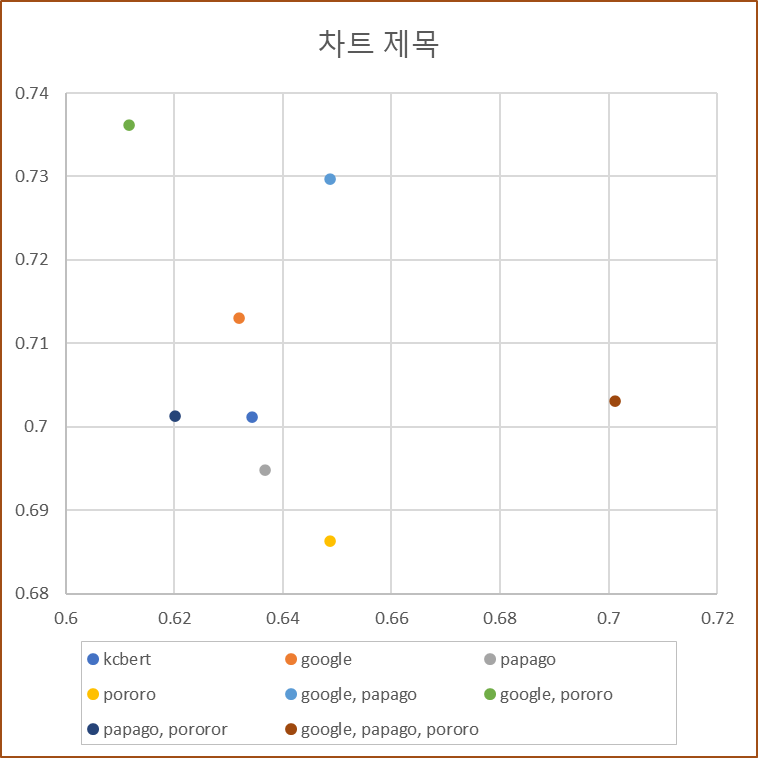

## 3. Dataset 로드

### 3-0. Pre-trained tokenizer 탐색

In [ ]:
# config.json 에서 지정 이름별로 가져올 라이브러리 지정

TOKENIZER_CLASSES = {
    "BertTokenizer": BertTokenizer,
    "AutoTokenizer": AutoTokenizer,
    "ElectraTokenizer": ElectraTokenizer,
    "AlbertTokenizer": AlbertTokenizer
}


- Tokenizer 사용 예시

In [ ]:
TOKENIZER = TOKENIZER_CLASSES[args.tokenizer_class].from_pretrained(args.pretrained_model)
if DEBUG==True:
    print(TOKENIZER)

Downloading:   0%|          | 0.00/244k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672 [00:00<?, ?B/s]

In [ ]:
if DEBUG == True:
    example = train_df['title'][0]
    comment_ex = train_df['comment'][0]
    print(TOKENIZER(example, comment_ex))

In [ ]:
if DEBUG==True:
    print(TOKENIZER.encode(example),"\n")
    
    # 토큰으로 나누기
    print(TOKENIZER.tokenize(example),"\n")
    
    # 토큰 id로 매핑하기
    print(TOKENIZER.convert_tokens_to_ids(TOKENIZER.tokenize(example)))


### 3-1. Dataset 만드는 함수 정의

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len, mode = 'train'):

        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mode = mode
        
        if self.mode!='test':
            try: 
                self.labels = df['label'].tolist()
            except:
                assert False, 'CustomDataset Error : \'label\' column does not exist in the dataframe'
     
    def __len__(self):
        return len(self.data)
                

    def __getitem__(self, idx):
        """
        전체 데이터에서 특정 인덱스 (idx)에 해당하는 기사제목과 댓글 내용을 
        토크나이즈한 data('input_ids', 'attention_mask','token_type_ids')의 딕셔너리 형태로 불러옴
        """
        title = self.data.title.iloc[idx]
        comment = self.data.comment.iloc[idx]
        
        tokenized_text = self.tokenizer(title, comment,
                             padding= 'max_length',
                             max_length=self.max_len,
                             truncation=True,
                             return_token_type_ids=True,
                             return_attention_mask=True,
                             return_tensors = "pt")
        
        data = {'input_ids': tokenized_text['input_ids'].clone().detach().long(),
               'attention_mask': tokenized_text['attention_mask'].clone().detach().long(),
               'token_type_ids': tokenized_text['token_type_ids'].clone().detach().long(),
               }
        
        if self.mode != 'test':
            label = self.data.label.iloc[idx]
            return data, label
        else:
            return data
        

    
train_dataset = CustomDataset(train_df, TOKENIZER, args.max_seq_len, mode ='train')
print("train dataset loaded.")

train dataset loaded.


In [ ]:
if DEBUG ==True :
    print("dataset sample : ")
    print(train_dataset[0])

In [ ]:
# encoded_plus = tokenizer.encode_plus(
#                     sentence,                      # Sentence to encode.
#                     add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                     max_length = 128,           # Pad & truncate all sentences.
#                     pad_to_max_length = True,
#                     return_attention_mask = True,   # Construct attention masks.
#                     return_tensors = 'pt',     # Return pytorch tensors.
#                )

### 3-2. Train, Validation set 나누기

In [ ]:
from sklearn.model_selection import train_test_split
                                                         
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=args.seed)

### (+alpha) aumentation 데이터 트레인에 추가
back tranlation

In [ ]:
train_data

,title,comment,bias,hate,pororo title,pororo comment,papago title,papago comment,google title,google comment,label
7086,박민영 드레스 하이힐 꽃다발 전력질주 김비서가 왜 그럴까,정말 현대의학의 힘은 대단하다는걸 느끼게해줌..,none,none,박민영의 드레스 하이힐 화단인 김 비서관이 어떻게 된 겁니까?,현대 의학을 정말 잘 느끼게 한다,박민영 원피스 하이힐 꽃다발 달리기 김비서. 뭐가 잘못됐나요?,현대 의학의 힘이 놀랍다는 것을 느끼게 합니다.,박민영 드레스 하이힐 부케 스프린트 김비서가 왜 그럴까?,현대의학의 힘이 대단하다는 것을 실감하게 됩니다.,0
5945,신동미 악성종양 고백 응원에 두렵고 떨렸다 정성 가득한 말에 힘 얻어,신동미 전부터 연기 잘한다고 생각했는데 왜그레 풍상씨에서 호소력 있는 연기 정말 좋...,none,none,신동미의 악성 종양 고백은 겁먹고 떨리며 본격적인 말로 힘을 얻었다.,"신동미 앞에서 연기를 잘하는 줄 알았는데 더 좋고 좋은 사람이라고 생각했는데, 남편...",신동미의 악성종양 고백에 무섭고 긴장됐다. 나는 그녀의 진심 어린 말에 힘이 났다.,"신동미가 예전부터 연기를 잘한다고 생각했는데 호소력 있는 연기가 정말 좋았고, 동상...",신동미의 악성종양 고백을 지지하는 모습이 두렵고 떨렸다.,예전에는 신동미가 연기를 잘한다고 생각했는데 왜거풍상에서 매력적인 연기가 너무 좋아...,0
1483,킬빌 산이 I 몰카 문구 논란 직접 입장 밝힐까,산이는 피해자 아닌가??누가 엿먹으라고 띄운것 같은데매갈???,gender,hate,숨겨진 카메라 문구에 대한 논란에 대해 킬빌 산이 직접 이야기할 것인가?,산이는 피해자인가요? 누가 한번 둘러보라고 한 것 같니?,윌. Killville은 나는 몰래 카메라에 대한 그의 입장을 밝혀야?,산도 피해자 아니야?누가 올려서 네가 망치라고 한 것 같아. 메이갈?,킬빌산이 '나 몰래카메라' 논란 속 입장 밝힐까?,산이가 피해자 아님?? 누가 날 엿먹이려고 올린거같은데??,5
3773,크레용팝 금미 2월 23일 결혼 예비신랑은 동갑내기 사업가,와 이쁘다 가을스튜디오네,none,none,지난 2월 23일 크레용 팝거무미의 결혼식은 같은 나이의 사업가다.,나는 아주 귀엽고 가을 스튜디오가 너무 귀엽다,크레용팝금미. 2월 23일 예비 신부는 동갑내기 사업가입니다.,"와, 예쁘다. 가을 스튜디오입니다.",크레용팝 금미는 오는 2월 23일 결혼식을 올린다. 신랑은 동갑내기 사업가다.,와~ 예쁜 가을 스튜디오네요.,0
8103,마이크로닷 산체스 부모 오늘 귀국 공항서 체포될듯,그래 죗값 치루면된다. 그리고 다시 방송에서 보자!,none,none,마이크로닷 산체스의 부모들이 오늘 공항에서 체포된다.,"그래, 우리는 그것을 지불해야 할 것이다 그리고 다시 방송에서 보자!",마이크로닷 산체스의 부모가 공항에서 체포될 예정이다.,"네, 당신은 그 범죄에 대한 대가를 치를 수 있습니다. 그리고 방송에서 또 만나요.",Microdot Sanchez의 부모는 오늘 집으로 돌아가는 공항에서 체포될 가능성...,"네, 대가를 치러야 합니다. 그리고 방송에서 다시 만나요!",0
...,...,...,...,...,...,...,...,...,...,...,...
5734,한예슬 측 지방종 수술 중 의료사고 당해 현재 치료중,이런글에 악플좀 달지마라. 진짜 얼마나 속상하겠냐. 악플달꺼면 글쓰지마..저런 실력...,none,none,한예슬의 지역 종양은 의료사고를 당했으며 현재 치료 중이다.,이 일에 나쁜 발언을 하지 마라 당신이 얼마나 화가 났나요? 악플을 쓰지 마세요. ...,한예슬은 지방종 수술 중 의료사고가 나 현재 치료를 받고 있다.,이런 댓글에 악플 달지 마세요. 그가 얼마나 화가 났을지 상상해 보세요. 악플을 남...,한예슬은 지방종 수술 중 의료사고를 당해 현재 치료를 받고 있다.,이 게시물에 나쁜 댓글을 달지 마십시오. 정말 얼마나 속상합니까? 악성댓글 싫으시면...,0
5191,방탄소년단 측 정국 열애설 사실 아냐 허위 사실에 법적 대응할 것,지인들 다 있는 자리에서 포옹한번 한거가지고 연애를 한다 어쩐다...게다가 cctv...,none,none,방탄소년단 간 정치적 관계설이 아닌 허위사실에 대한 법적 대응,나는 모든 지인들을 한 번 사랑하고 있다 그 외에도 CCTV를 파헤쳐 나갈 거야,방탄소년단의 열애설은 사실이 아닙니다. 잘못된 정보에 대한 법적 조치.,"모든 사람들을 위해 이 방에서 연주를 하는 포옹이 무슨 소용인가...게다가, CCT...","방탄소년단 정국 열애설 사실무근, 허위사실에 대해 법적 대응",지인들이 다 있는 곳에서 한 번의 포옹으로 사랑에 빠지고...,0
5390,이승기X심은경 궁합 1만 돌파 로맨스 잔혹사 끊었다.,마지막에 이승기 죽습니다,none,none,심은경 이승기가 총 1만 명의 로맨스 잔혹한 역사를 끊었다.,결국 이승기가 죽는다.,이승기X심이 1만 궁합이 넘는 만행을 깼다.,이승기는 마지막에 죽을 거야.,이승기X심은경의 궁합이 100만 로맨스 잔혹성을 돌파했다.,이승기는 결국 죽는다.,0
860,9kg 인증 몸무게 공개 실검 1위 찍은 녀연예인,166에 57.4 다이어트 필요없지만건강위해더뺄거야다들 더마르게봄,none,none,무게 9㎏으로 대중 1위를 차지한 여성 연예인,66-57.4 다이어트는 필요 없지만 건강을 위해서는 더 나아질 것이다,누가 1일부터 실시간 검색 순위에 9kg 무게를 차지했다 그 여성 연예인.,"166과 57.4 다이어트는 필요 없지만, 건강을 위해 살을 뺄 거예요. 다들 내가...",90kg 인증체중 공개검사에서 1위를 차지한 연예인들,166 to 57.4 다이어트는 필요없지만 건강을 위해 더 빼겠습니다. 다들 날씬해...,0


In [ ]:
pororo = pd.concat([train_data.iloc[:,4:6], train_data.iloc[:,2:4], train_data.iloc[:,-1]], axis=1)
papago = pd.concat([train_data.iloc[:,6:8], train_data.iloc[:,2:4], train_data.iloc[:,-1]], axis=1)
google = pd.concat([train_data.iloc[:,8:10], train_data.iloc[:,2:4], train_data.iloc[:,-1]], axis=1)

pororo = pororo.rename(columns = {'pororo title': 'title', 'pororo comment': 'comment'})
papago = papago.rename(columns = {'papago title': 'title', 'papago comment': 'comment'})
google = google.rename(columns = {'google title': 'title', 'google comment': 'comment'})

google

,title,comment,bias,hate,label
7086,박민영 드레스 하이힐 부케 스프린트 김비서가 왜 그럴까?,현대의학의 힘이 대단하다는 것을 실감하게 됩니다.,none,none,0
5945,신동미의 악성종양 고백을 지지하는 모습이 두렵고 떨렸다.,예전에는 신동미가 연기를 잘한다고 생각했는데 왜거풍상에서 매력적인 연기가 너무 좋아...,none,none,0
1483,킬빌산이 '나 몰래카메라' 논란 속 입장 밝힐까?,산이가 피해자 아님?? 누가 날 엿먹이려고 올린거같은데??,gender,hate,5
3773,크레용팝 금미는 오는 2월 23일 결혼식을 올린다. 신랑은 동갑내기 사업가다.,와~ 예쁜 가을 스튜디오네요.,none,none,0
8103,Microdot Sanchez의 부모는 오늘 집으로 돌아가는 공항에서 체포될 가능성...,"네, 대가를 치러야 합니다. 그리고 방송에서 다시 만나요!",none,none,0
...,...,...,...,...,...
5734,한예슬은 지방종 수술 중 의료사고를 당해 현재 치료를 받고 있다.,이 게시물에 나쁜 댓글을 달지 마십시오. 정말 얼마나 속상합니까? 악성댓글 싫으시면...,none,none,0
5191,"방탄소년단 정국 열애설 사실무근, 허위사실에 대해 법적 대응",지인들이 다 있는 곳에서 한 번의 포옹으로 사랑에 빠지고...,none,none,0
5390,이승기X심은경의 궁합이 100만 로맨스 잔혹성을 돌파했다.,이승기는 결국 죽는다.,none,none,0
860,90kg 인증체중 공개검사에서 1위를 차지한 연예인들,166 to 57.4 다이어트는 필요없지만 건강을 위해 더 빼겠습니다. 다들 날씬해...,none,none,0


In [ ]:
# 추가 데이터
train_data = pd.concat([train_data.iloc[:,0:4], train_data.iloc[:,-1]], axis=1)
train_data = pd.concat([train_data, google, pororo], axis=0, ignore_index=True)
train_data

,title,comment,bias,hate,label
0,박민영 드레스 하이힐 꽃다발 전력질주 김비서가 왜 그럴까,정말 현대의학의 힘은 대단하다는걸 느끼게해줌..,none,none,0
1,신동미 악성종양 고백 응원에 두렵고 떨렸다 정성 가득한 말에 힘 얻어,신동미 전부터 연기 잘한다고 생각했는데 왜그레 풍상씨에서 호소력 있는 연기 정말 좋...,none,none,0
2,킬빌 산이 I 몰카 문구 논란 직접 입장 밝힐까,산이는 피해자 아닌가??누가 엿먹으라고 띄운것 같은데매갈???,gender,hate,5
3,크레용팝 금미 2월 23일 결혼 예비신랑은 동갑내기 사업가,와 이쁘다 가을스튜디오네,none,none,0
4,마이크로닷 산체스 부모 오늘 귀국 공항서 체포될듯,그래 죗값 치루면된다. 그리고 다시 방송에서 보자!,none,none,0
...,...,...,...,...,...
22585,한예슬의 지역 종양은 의료사고를 당했으며 현재 치료 중이다.,이 일에 나쁜 발언을 하지 마라 당신이 얼마나 화가 났나요? 악플을 쓰지 마세요. ...,none,none,0
22586,방탄소년단 간 정치적 관계설이 아닌 허위사실에 대한 법적 대응,나는 모든 지인들을 한 번 사랑하고 있다 그 외에도 CCTV를 파헤쳐 나갈 거야,none,none,0
22587,심은경 이승기가 총 1만 명의 로맨스 잔혹한 역사를 끊었다.,결국 이승기가 죽는다.,none,none,0
22588,무게 9㎏으로 대중 1위를 차지한 여성 연예인,66-57.4 다이어트는 필요 없지만 건강을 위해서는 더 나아질 것이다,none,none,0


In [ ]:
train_dataset = CustomDataset(train_data, TOKENIZER, args.max_seq_len, 'train')
val_dataset = CustomDataset(val_data, TOKENIZER, args.max_seq_len, 'validation')

print("Train dataset: ", len(train_dataset))
print("Validation dataset: ", len(val_dataset))

Train dataset:  22590
Validation dataset:  837


## 4. 분류 모델 학습을 위한 세팅

### 4-1. 아키텍쳐 설정




- [PretrainedConfig](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/configuration#transformers.PretrainedConfig.from_pretrained)
-[KcELECTRA 사전학습 모델](https://github.com/Beomi/KcELECTRA)

In [ ]:
from transformers import logging
logging.set_verbosity_error()

# config.json 에 입력된 architecture 에 따라 베이스 모델 설정
BASE_MODELS = {
    "BertForSequenceClassification": BertForSequenceClassification,
    "AutoModel": AutoModel,
    'AutoModelForSequenceClassification' : AutoModelForSequenceClassification,
    "ElectraForSequenceClassification": ElectraForSequenceClassification,
    "AlbertForSequenceClassification": AlbertForSequenceClassification,

}


myModel = BASE_MODELS[args.architecture].from_pretrained(args.pretrained_model, 
                                                         num_labels = args.num_classes, 
                                                         output_attentions = False, # Whether the model returns attentions weights.
                                                         output_hidden_states = True # Whether the model returns all hidden-states.
                                                        )
if DEBUG==True:
    # 모델 구조 확인
    print(myModel)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [ ]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

### 4-2. 모델 설정


- BertForSequenceClassifier (line 1232부터 참고) [source code](https://github.com/huggingface/transformers/blob/a39dfe4fb122c11be98a563fb8ca43b322e01036/src/transformers/modeling_bert.py#L1284-L1287)

- ElectraForSequenceClassifier [source code](https://huggingface.co/transformers/v3.0.2/_modules/transformers/modeling_electra.html#ElectraForSequenceClassification)

- SequenceClassier output 형태 : tuple(torch.FloatTensor)
    - loss (torch.FloatTensor of shape (1,), optional, returned when label is provided):
    Classification (or regression if config.num_labels==1) loss.

   - logits (torch.FloatTensor of shape (batch_size, config.num_labels)):
    Classification (or regression if config.num_labels==1) scores (before SoftMax).

    - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True):
    Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).

    - Hidden-states of the model at the output of each layer plus the initial embedding outputs.

    - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True):
Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

    Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
    
    
- v2 에서 수정 및 추가 된 부분 많음



In [ ]:
### v2 에서 일부 수정됨
class myClassifier(nn.Module):
    def __init__(self, model, hidden_size = 768, num_classes=args.num_classes, selected_layers=False, params=None):
        super(myClassifier, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1) 
        self.selected_layers = selected_layers
        
        # 사실 dr rate은 model config 에서 hidden_dropout_prob로 가져와야 하는데 bert에선 0.1이 쓰였음
        self.dropout = nn.Dropout(0.1)


    def forward(self, token_ids, attention_mask, segment_ids):      
        outputs = self.model(input_ids = token_ids, 
                             token_type_ids = segment_ids.long(), 
                             attention_mask = attention_mask.float().to(token_ids.device))
        
        # hidden state에서 마지막 4개 레이어를 뽑아 합쳐 새로운 pooled output 을 만드는 시도
        if self.selected_layers == True:
            hidden_states = outputs.hidden_states
            pooled_output = torch.cat(tuple([hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
            # print("concatenated output shape: ", pooled_output.shape)
            ## dim(batch_size, max_seq_len, hidden_dim) 에서 가운데를 0이라 지정함으로, [cls] 토큰의 임베딩을 가져온다. 
            ## (text classification 구조 참고)
            pooled_output = pooled_output[:, 0, :]
            # print(pooled_output)

            pooled_output = self.dropout(pooled_output)

            ## 3개의 레이어를 합치므로 classifier의 차원은 (hidden_dim, 6)이다
            classifier = nn.Linear(pooled_output.shape[1], args.num_classes).to(token_ids.device)
            logits = classifier(pooled_output)
        
        else:
            logits=outputs.logits
        
    
        # 각 클래스별 확률
        prob= self.softmax(logits)
        # print(prob)
        # logits2 = outputs.logits
        # print(self.softmax(logits2))


        return logits, prob
        
# 마지막 4 hidden layers concat 하는 방법을 쓰신다면 True로 변경        
model = myClassifier(myModel, selected_layers=False)

# if DEBUG ==True :
#     print(model)

### 4-3. 모델 구성 확인

In [ ]:
if DEBUG==True:
    params = list(model.named_parameters())

    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

## 5. 학습 진행

### 5-0. Early Stopper 함수 정의

기존의 베이스 라인이 val loss 기준으로 작동했는데 val f1-score기준으로 변경했다.

In [ ]:
class LossEarlyStopper():
    """Early stopper

        patience (int): f1 score가 증가하지 않아도 학습할 epoch 수
        patience_counter (int): f1 score가 증가하지 않을 때 마다 1씩 증가
        max_score (float): 최대 f1 score
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        """ 초기화

        Args:
            patience (int): f1 score가 증가하지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.patience_counter = 0
        self.max_score = 0
        self.stop = False

    def check_early_stopping(self, score: float)-> None:
        # 첫 에폭
        if self.max_score == 0:
            self.max_score = score
           
        # loss가 줄지 않는다면 -> patience_counter 1 증가
        elif score < self.max_score:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            # patience 만큼 loss가 줄지 않았다면 학습을 중단합니다.
            if self.patience_counter == self.patience:
                self.stop = True
            print(msg)
        # loss가 줄어듬 -> min_loss 갱신, patience_counter 초기화
        elif score >= self.max_score:
            self.patience_counter = 0
            ### v2 에서 수정됨
            ### self.save_model = True -> 삭제 (사용하지 않음)
            msg = f"Validation score increased {self.max_score} -> {score}"
            self.max_score = score

            print(msg)

### 5-1. Epoch 별 학습 및 검증

- [Transformers optimization documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules)
- [스케줄러 documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules)
- Adam optimizer의 epsilon 파라미터 eps = 1e-8 는 "계산 중 0으로 나눔을 방지 하기 위한 아주 작은 숫자 " 입니다. ([출처](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))
- 스케줄러 파라미터
    - `warmup_ratio` : 
      - 학습이 진행되면서 학습률을 그 상황에 맞게 가변적으로 적당하게 변경되게 하기 위해 Scheduler를 사용합니다.
      - 처음 학습률(Learning rate)를 warm up하기 위한 비율을 설정하는 warmup_ratio을 설정합니다.
  

기존의 베이스 라인의 loss 함수가 bias와 hate둘다 맞춰야 맞는 데이터로 계산했다.
loss function을 bias, hate 각 각 계산 하는 것으로 변경했지만 좋은 결과를 얻지 못했다.

또한 val f1-score 계산 부분을 추가하여 사용했다.

In [ ]:
args = set_config(config_path)

logging.set_verbosity_warning()

# 재현을 위해 모든 곳의 시드 고정
seed_val = args.seed
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



def train(model, train_data, val_data, args, mode = 'train'):
    
    # args.run은 실험 이름 (어디까지나 팀원들간의 버전 관리 및 공유 편의를 위한 것으로, 자유롭게 수정 가능합니다.)
    print("RUN : ", args.run)
    shutil.copyfile(f'{PATH}config.json', os.path.join(args.config_dir, f"config_{args.run}.json"))

    early_stopper = LossEarlyStopper(patience=args.patience)
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=args.train_batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=args.train_batch_size)

    step_limt = 236 # 기존 데이터는 236 step 만큼 한 에폭당 실행된다.

    bias_tensor = torch.FloatTensor([[1,0,0],
                                    [1,0,0],
                                    [0,1,0],
                                    [0,1,0],
                                    [0,0,1],
                                    [0,0,1]])
    hate_tensor = torch.FloatTensor([[1,0],
                                     [0,1],
                                     [1,0],
                                     [0,1],
                                     [1,0],
                                     [0,1]])   


    if DEBUG == True:
        # 데이터로더가 성공적으로 로드 되었는지 확인
        for idx, data in enumerate(train_dataloader):
            if idx==0:
                print("batch size : ", len(data[0]['input_ids']))
                print("The first batch looks like ..\n", data[0])
    
    
    criterion = nn.CrossEntropyLoss()
    
    total_steps = len(train_dataloader) * args.train_epochs

    ### v2에서 수정됨 (Adam -> AdamW)
    optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * args.warmup_proportion), 
                                                num_training_steps=total_steps)

    
    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
        

    tr_loss = 0.0
    val_loss = 0.0
    best_score = 0.0
    best_loss =0.0
      

    for epoch_num in range(args.train_epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_f1_train = 0
            
            assert mode in ['train', 'val'], 'your mode should be either \'train\' or \'val\''
            
            if mode =='train':
                step = 0
                for train_input, train_label in tqdm(train_dataloader):  # 데이터가 늘어난 만큼 에폭당 스텝수가 늘어나기 때문에 여기서 스텝의 수를 제한다(어리스탑어의 기능을 일정하게 하기위해서)
                    step += 1
                    if step == (step_limt + 1): # 기존 데이터는 236 step 만큼 한 에폭당 실행된다. (32 베치 사이즈 기준)
                        break

                    mask = train_input['attention_mask'].to(DEVICE)
                    input_id = train_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = train_input['token_type_ids'].squeeze(1).to(DEVICE)
                    train_label = train_label.long().to(DEVICE)
                    bias_tensor = bias_tensor[:].to(DEVICE)
                    hate_tensor = hate_tensor[:].to(DEVICE)

                    bias_label = torch.div(train_label.view(-1), 2, rounding_mode='trunc')
                    hate_label = torch.remainder(train_label.view(-1), 2)

                    output = model(input_id, mask, segment_ids)
                    bias_output = torch.mm(output[0].view(-1,6), bias_tensor)
                    hate_output = torch.mm(output[0].view(-1,6), hate_tensor)

                    batch_loss = criterion(output[0].view(-1,6), train_label.view(-1))
                    total_loss_train += batch_loss.item()

                    acc = (output[0].argmax(dim=1) == train_label).sum().item()
                    total_acc_train += acc

                    f1_bias = f1_score(bias_label.cpu().tolist(), bias_output.argmax(dim=1).cpu().tolist(), average='macro')
                    f1_hate = f1_score(hate_label.cpu().tolist(), hate_output.argmax(dim=1).cpu().tolist(), average='macro')
                    total_f1_train += (f1_bias + f1_hate) / 2
                    
                    ### v2에 수정됨
                    optimizer.zero_grad()
                    
                    batch_loss.backward()
                    optimizer.step()
                    
                    ### v2 에 수정됨
                    scheduler.step()
                    

            total_acc_val = 0
            total_loss_val = 0
            total_f1_val = 0
            
            # validation을 위해 이걸 넣으면 이 evaluation 프로세스 중엔 dropout 레이어가 다르가 동작한다.
            model.eval()
            
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    mask = val_input['attention_mask'].to(DEVICE)
                    input_id = val_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = val_input['token_type_ids'].squeeze(1).to(DEVICE)
                    val_label = val_label.long().to(DEVICE)
                    bias_tensor = bias_tensor[:].to(DEVICE)
                    hate_tensor = hate_tensor[:].to(DEVICE)

                    bias_label = torch.div(val_label.view(-1), 2, rounding_mode='trunc')
                    hate_label = torch.remainder(val_label.view(-1), 2)

                    output = model(input_id, mask, segment_ids)
                    bias_output = torch.mm(output[0].view(-1,6), bias_tensor)
                    hate_output = torch.mm(output[0].view(-1,6), hate_tensor)

                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    batch_loss = criterion(output[0].view(-1,6), val_label.view(-1))
                    total_loss_val += batch_loss.item()
                    
                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    acc = (output[0].argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

                    f1_bias = f1_score(bias_label.cpu().tolist(), bias_output.argmax(dim=1).cpu().tolist(), average='macro')
                    f1_hate = f1_score(hate_label.cpu().tolist(), hate_output.argmax(dim=1).cpu().tolist(), average='macro')
                    total_f1_val += (f1_bias + f1_hate) / 2
            
            
            train_loss = total_loss_train / step_limt
            train_accuracy = total_acc_train / step_limt
            train_f1 = total_f1_train / step_limt
            val_loss = total_loss_val / len(val_data)
            val_accuracy = total_acc_val / len(val_data)
            val_f1 = total_f1_val / len(val_dataloader)
            
            # 한 Epoch 학습 후 학습/검증에 대해 loss와 평가지표 (여기서는 accuracy로 임의로 설정) 출력
            print(
                f'Epoch: {epoch_num + 1} \
                | Train Loss: {train_loss: .3f} \
                | Train Accuracy: {train_accuracy: .3f} \
                | Train F1-score: {train_f1: .3f} \
                | Val Loss: {val_loss: .3f} \
                | Val Accuracy: {val_accuracy: .3f} \
                | Val F1-score: {val_f1: .3f}')
          
            # early_stopping check
            early_stopper.check_early_stopping(score=val_f1)

            if early_stopper.stop:
                print('Early stopped, Best score : ', best_score)
                break

            ### v2 에 수정됨
            ### loss와 accuracy가 꼭 correlate하진 않습니다.
            ### 
            ### 원본 (필요하다면 다시 해제 후 사용)
            # if val_accuracy > best_score : 
            if epoch_num == 0 or val_f1 > best_score :
            # 모델이 개선됨 -> 검증 점수와 베스트 loss, weight 갱신
                best_score = val_f1 
                
                ### v2에서 추가
                best_loss = val_loss
                # 학습된 모델을 저장할 디렉토리 및 모델 이름 지정
                SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')
            
                check_point = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict()
                }
                torch.save(check_point, SAVED_MODEL)   
              
            # print("scheduler : ", scheduler.state_dict())


    print("train finished")


train(model, train_dataset, val_dataset, args, mode = 'train')

config file loaded.
beomi/kcbert-large
RUN :  f1 score google, pororo, large


 33%|███▎      | 236/706 [04:50<09:39,  1.23s/it]


Epoch: 1                 | Train Loss:  1.841                 | Train Accuracy:  4.144                 | Train F1-score:  0.346                 | Val Loss:  0.058                 | Val Accuracy:  0.174                 | Val F1-score:  0.345


 33%|███▎      | 236/706 [04:51<09:40,  1.24s/it]


Epoch: 2                 | Train Loss:  1.779                 | Train Accuracy:  7.081                 | Train F1-score:  0.375                 | Val Loss:  0.056                 | Val Accuracy:  0.330                 | Val F1-score:  0.383
Validation score increased 0.34450018551939626 -> 0.38288280367415367


 33%|███▎      | 236/706 [04:50<09:37,  1.23s/it]


Epoch: 3                 | Train Loss:  1.688                 | Train Accuracy:  11.186                 | Train F1-score:  0.388                 | Val Loss:  0.052                 | Val Accuracy:  0.413                 | Val F1-score:  0.395
Validation score increased 0.38288280367415367 -> 0.39497057178161876


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 4                 | Train Loss:  1.592                 | Train Accuracy:  12.843                 | Train F1-score:  0.382                 | Val Loss:  0.049                 | Val Accuracy:  0.428                 | Val F1-score:  0.396
Validation score increased 0.39497057178161876 -> 0.3960986988639232


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 5                 | Train Loss:  1.527                 | Train Accuracy:  12.881                 | Train F1-score:  0.348                 | Val Loss:  0.047                 | Val Accuracy:  0.429                 | Val F1-score:  0.348
Early stopping counter 1/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 6                 | Train Loss:  1.460                 | Train Accuracy:  13.140                 | Train F1-score:  0.318                 | Val Loss:  0.045                 | Val Accuracy:  0.429                 | Val F1-score:  0.319
Early stopping counter 2/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 7                 | Train Loss:  1.426                 | Train Accuracy:  13.191                 | Train F1-score:  0.312                 | Val Loss:  0.044                 | Val Accuracy:  0.431                 | Val F1-score:  0.317
Early stopping counter 3/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 8                 | Train Loss:  1.392                 | Train Accuracy:  13.237                 | Train F1-score:  0.312                 | Val Loss:  0.043                 | Val Accuracy:  0.438                 | Val F1-score:  0.316
Early stopping counter 4/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 9                 | Train Loss:  1.352                 | Train Accuracy:  13.530                 | Train F1-score:  0.312                 | Val Loss:  0.042                 | Val Accuracy:  0.440                 | Val F1-score:  0.316
Early stopping counter 5/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 10                 | Train Loss:  1.321                 | Train Accuracy:  13.716                 | Train F1-score:  0.311                 | Val Loss:  0.040                 | Val Accuracy:  0.458                 | Val F1-score:  0.316
Early stopping counter 6/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 11                 | Train Loss:  1.290                 | Train Accuracy:  14.042                 | Train F1-score:  0.313                 | Val Loss:  0.039                 | Val Accuracy:  0.490                 | Val F1-score:  0.316
Early stopping counter 7/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 12                 | Train Loss:  1.248                 | Train Accuracy:  15.110                 | Train F1-score:  0.311                 | Val Loss:  0.037                 | Val Accuracy:  0.516                 | Val F1-score:  0.319
Early stopping counter 8/15


 33%|███▎      | 236/706 [04:48<09:33,  1.22s/it]


Epoch: 13                 | Train Loss:  1.204                 | Train Accuracy:  16.602                 | Train F1-score:  0.322                 | Val Loss:  0.036                 | Val Accuracy:  0.582                 | Val F1-score:  0.333
Early stopping counter 9/15


 33%|███▎      | 236/706 [04:48<09:33,  1.22s/it]


Epoch: 14                 | Train Loss:  1.169                 | Train Accuracy:  17.377                 | Train F1-score:  0.347                 | Val Loss:  0.034                 | Val Accuracy:  0.612                 | Val F1-score:  0.378
Early stopping counter 10/15


 33%|███▎      | 236/706 [04:48<09:33,  1.22s/it]


Epoch: 15                 | Train Loss:  1.123                 | Train Accuracy:  17.877                 | Train F1-score:  0.400                 | Val Loss:  0.033                 | Val Accuracy:  0.624                 | Val F1-score:  0.447
Validation score increased 0.3960986988639232 -> 0.44715317553975426


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 16                 | Train Loss:  1.070                 | Train Accuracy:  18.602                 | Train F1-score:  0.467                 | Val Loss:  0.031                 | Val Accuracy:  0.645                 | Val F1-score:  0.506
Validation score increased 0.44715317553975426 -> 0.5063671592789265


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 17                 | Train Loss:  1.034                 | Train Accuracy:  19.386                 | Train F1-score:  0.506                 | Val Loss:  0.030                 | Val Accuracy:  0.639                 | Val F1-score:  0.543
Validation score increased 0.5063671592789265 -> 0.5434787923860991


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 18                 | Train Loss:  1.007                 | Train Accuracy:  19.644                 | Train F1-score:  0.530                 | Val Loss:  0.030                 | Val Accuracy:  0.655                 | Val F1-score:  0.574
Validation score increased 0.5434787923860991 -> 0.5736243140878701


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 19                 | Train Loss:  0.990                 | Train Accuracy:  19.831                 | Train F1-score:  0.545                 | Val Loss:  0.030                 | Val Accuracy:  0.661                 | Val F1-score:  0.591
Validation score increased 0.5736243140878701 -> 0.5906643087384621


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 20                 | Train Loss:  0.959                 | Train Accuracy:  20.513                 | Train F1-score:  0.576                 | Val Loss:  0.029                 | Val Accuracy:  0.658                 | Val F1-score:  0.609
Validation score increased 0.5906643087384621 -> 0.6088354624881999


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 21                 | Train Loss:  0.901                 | Train Accuracy:  21.386                 | Train F1-score:  0.617                 | Val Loss:  0.029                 | Val Accuracy:  0.657                 | Val F1-score:  0.623
Validation score increased 0.6088354624881999 -> 0.6231847909586279


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 22                 | Train Loss:  0.881                 | Train Accuracy:  21.470                 | Train F1-score:  0.631                 | Val Loss:  0.029                 | Val Accuracy:  0.649                 | Val F1-score:  0.636
Validation score increased 0.6231847909586279 -> 0.635797778423209


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 23                 | Train Loss:  0.838                 | Train Accuracy:  22.237                 | Train F1-score:  0.653                 | Val Loss:  0.029                 | Val Accuracy:  0.643                 | Val F1-score:  0.644
Validation score increased 0.635797778423209 -> 0.6442811497231363


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 24                 | Train Loss:  0.803                 | Train Accuracy:  22.915                 | Train F1-score:  0.675                 | Val Loss:  0.029                 | Val Accuracy:  0.645                 | Val F1-score:  0.659
Validation score increased 0.6442811497231363 -> 0.659078677381327


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 25                 | Train Loss:  0.759                 | Train Accuracy:  23.381                 | Train F1-score:  0.703                 | Val Loss:  0.029                 | Val Accuracy:  0.654                 | Val F1-score:  0.689
Validation score increased 0.659078677381327 -> 0.6893338240179966


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 26                 | Train Loss:  0.710                 | Train Accuracy:  24.047                 | Train F1-score:  0.732                 | Val Loss:  0.029                 | Val Accuracy:  0.636                 | Val F1-score:  0.699
Validation score increased 0.6893338240179966 -> 0.6988422676183814


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 27                 | Train Loss:  0.672                 | Train Accuracy:  24.720                 | Train F1-score:  0.761                 | Val Loss:  0.029                 | Val Accuracy:  0.636                 | Val F1-score:  0.710
Validation score increased 0.6988422676183814 -> 0.7096354289917497


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 28                 | Train Loss:  0.614                 | Train Accuracy:  25.470                 | Train F1-score:  0.782                 | Val Loss:  0.031                 | Val Accuracy:  0.626                 | Val F1-score:  0.700
Early stopping counter 1/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 29                 | Train Loss:  0.582                 | Train Accuracy:  25.805                 | Train F1-score:  0.807                 | Val Loss:  0.031                 | Val Accuracy:  0.640                 | Val F1-score:  0.712
Validation score increased 0.7096354289917497 -> 0.7119801790039794


 33%|███▎      | 236/706 [04:49<09:35,  1.23s/it]


Epoch: 30                 | Train Loss:  0.526                 | Train Accuracy:  26.517                 | Train F1-score:  0.828                 | Val Loss:  0.031                 | Val Accuracy:  0.631                 | Val F1-score:  0.714
Validation score increased 0.7119801790039794 -> 0.7144917743651531


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 31                 | Train Loss:  0.488                 | Train Accuracy:  26.928                 | Train F1-score:  0.849                 | Val Loss:  0.032                 | Val Accuracy:  0.630                 | Val F1-score:  0.720
Validation score increased 0.7144917743651531 -> 0.7204763074458618


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 32                 | Train Loss:  0.433                 | Train Accuracy:  27.653                 | Train F1-score:  0.871                 | Val Loss:  0.033                 | Val Accuracy:  0.622                 | Val F1-score:  0.715
Early stopping counter 1/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 33                 | Train Loss:  0.395                 | Train Accuracy:  28.169                 | Train F1-score:  0.887                 | Val Loss:  0.034                 | Val Accuracy:  0.627                 | Val F1-score:  0.724
Validation score increased 0.7204763074458618 -> 0.7243056963944267


 33%|███▎      | 236/706 [04:48<09:35,  1.22s/it]


Epoch: 34                 | Train Loss:  0.360                 | Train Accuracy:  28.500                 | Train F1-score:  0.898                 | Val Loss:  0.035                 | Val Accuracy:  0.632                 | Val F1-score:  0.730
Validation score increased 0.7243056963944267 -> 0.7300401987859362


 33%|███▎      | 236/706 [04:49<09:35,  1.22s/it]


Epoch: 35                 | Train Loss:  0.316                 | Train Accuracy:  29.034                 | Train F1-score:  0.915                 | Val Loss:  0.036                 | Val Accuracy:  0.624                 | Val F1-score:  0.723
Early stopping counter 1/15


 33%|███▎      | 236/706 [04:48<09:33,  1.22s/it]


Epoch: 36                 | Train Loss:  0.271                 | Train Accuracy:  29.555                 | Train F1-score:  0.923                 | Val Loss:  0.038                 | Val Accuracy:  0.622                 | Val F1-score:  0.727
Early stopping counter 2/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 37                 | Train Loss:  0.240                 | Train Accuracy:  29.839                 | Train F1-score:  0.938                 | Val Loss:  0.039                 | Val Accuracy:  0.612                 | Val F1-score:  0.720
Early stopping counter 3/15


 33%|███▎      | 236/706 [04:48<09:34,  1.22s/it]


Epoch: 38                 | Train Loss:  0.218                 | Train Accuracy:  30.161                 | Train F1-score:  0.943                 | Val Loss:  0.040                 | Val Accuracy:  0.614                 | Val F1-score:  0.717
Early stopping counter 4/15


  2%|▏         | 12/706 [00:15<15:15,  1.32s/it]


KeyboardInterrupt: ignored

### (+alpha) 모델 실험  
 ACC - public score  
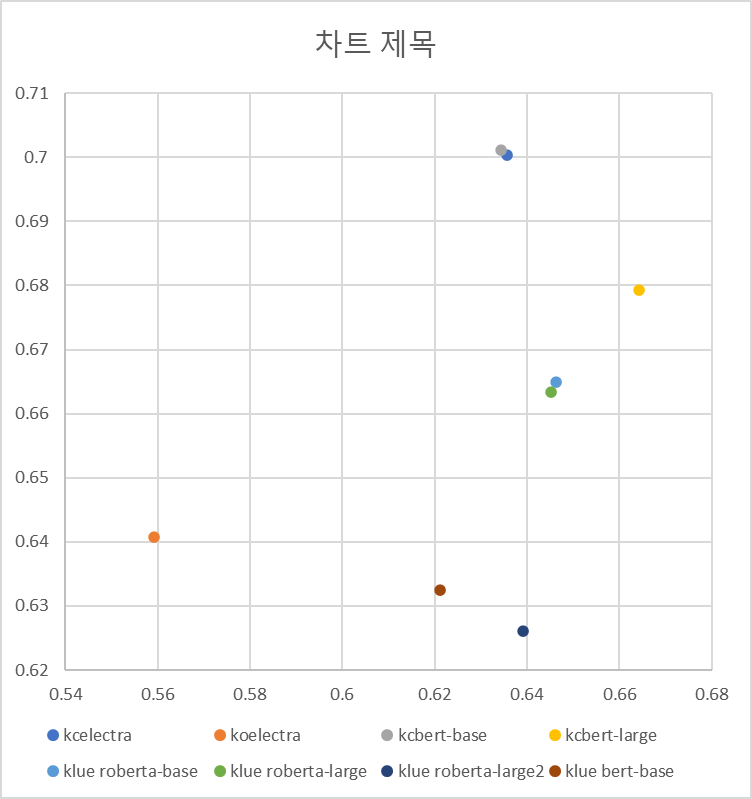

추가 실험  
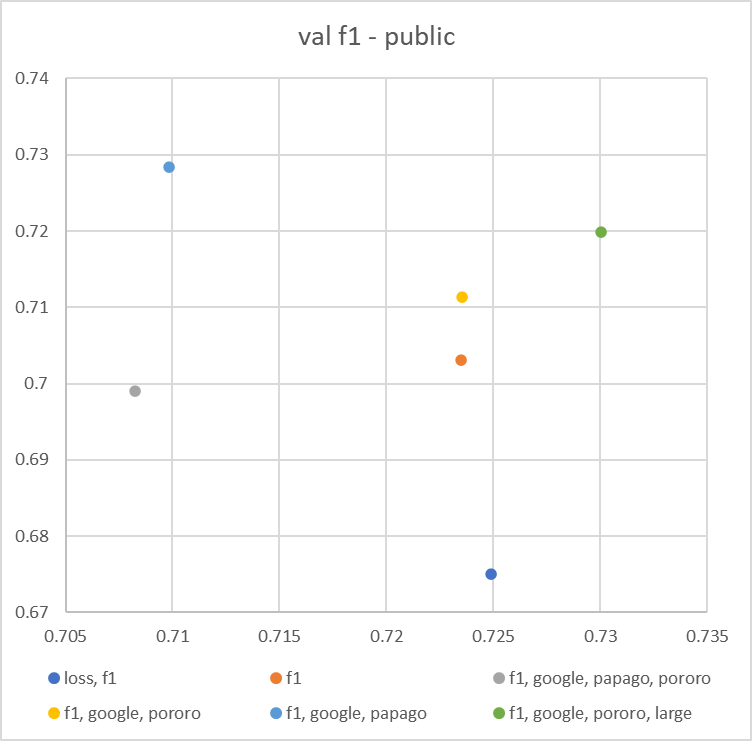

최종 선택 모델은 kcbert-large이고
번역 데이터는 구글 번역과 포로로를 사용했고
f1-score를 기준으로 Early Stopper를 사용했다.

## 6. Test dataset으로 추론 (Prediction)


- v2 에서 수정된 부분
    - output -> output[0]

In [ ]:
test_df.loc[train_df['title'].isnull() == True]

,ID,title,comment


In [ ]:
from torch.utils.data import DataLoader

# 테스트 데이터셋 불러오기
test_data = CustomDataset(test_df, tokenizer = TOKENIZER, max_len= args.max_seq_len, mode='test')

def test(model, SAVED_MODEL, test_data, args, mode = 'test'):


    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=args.eval_batch_size)


    if use_cuda:

        model = model.to(DEVICE)
        model.load_state_dict(torch.load(SAVED_MODEL)['model'])


    model.eval()

    pred = []

    with torch.no_grad():
        for test_input in test_dataloader:

            mask = test_input['attention_mask'].to(DEVICE)
            input_id = test_input['input_ids'].squeeze(1).to(DEVICE)
            segment_ids = test_input['token_type_ids'].squeeze(1).to(DEVICE)

            output = model(input_id, mask, segment_ids)

            output = output[0].argmax(dim=1).cpu().tolist()

            for label in output:
                pred.append(label)
                
    return pred

SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')

pred = test(model, SAVED_MODEL, test_data, args)

In [ ]:
print("prediction completed for ", len(pred), "comments")


prediction completed for  511 comments


### 

In [ ]:
# 0-5 사이의 라벨 값 별로 bias, hate로 디코딩 하기 위한 딕셔너리
bias_dict = {0: 'none', 1: 'none', 2: 'others', 3:'others', 4:'gender', 5:'gender'}
hate_dict = {0: 'none', 1: 'hate', 2: 'none', 3:'hate', 4:'none', 5:'hate'}

# 인코딩 값으로 나온 타겟 변수를 디코딩
pred_bias = ['' for i in range(len(pred))]
pred_hate = ['' for i in range(len(pred))]

for idx, label in enumerate(pred):
    pred_bias[idx]=(str(bias_dict[label]))
    pred_hate[idx]=(str(hate_dict[label]))
print('decode Completed!')



decode Completed!


In [ ]:
submit = pd.read_csv(os.path.join(args.data_dir,'sample_submission.csv'))
submit

,ID,bias,hate
0,0,none,none
1,1,none,none
2,2,none,none
3,3,none,none
4,4,none,none
...,...,...,...
506,506,none,none
507,507,none,none
508,508,none,none
509,509,none,none


In [ ]:
submit['bias'] = pred_bias
submit['hate'] = pred_hate
submit

,ID,bias,hate
0,0,none,none
1,1,none,none
2,2,none,hate
3,3,others,hate
4,4,others,hate
...,...,...,...
506,506,none,hate
507,507,none,none
508,508,none,hate
509,509,none,none


In [ ]:
submit.to_csv(os.path.join(args.result_dir, f"submission_{args.run}.csv"), index=False)